In [5]:
import pandas as pd # To structure and manipulated data in a DataFrame format
import geopandas as gpd # To work with spatial data in a DataFrame
from geopandas import GeoDataFrame # To create a GeoDataFrame from a DataFrame
from shapely.geometry import LineString # To create line geometries that can be used in a GeoDataFrame
import folium # To generate a Leaflet-based map of my data throughout my analysis 

In [6]:
fname = '/media/psf/Home/Downloads/Run_to_the_hills_.gpx'

In [7]:
gdf = gpd.read_file(fname, layer = 'track_points')
gdf.sort_values('track_seg_point_id', inplace=True)
gdf.reset_index(drop=True, inplace=True)
gdf = gdf[['track_seg_point_id', 'ele', 'time', 'geometry']].copy()
gdf.head()

track_seg_point_id   ele                 time                   geometry
0                   0  78.9  2020-06-04T16:10:32  POINT (-0.93348 51.01355)
1                   1  78.9  2020-06-04T16:10:33  POINT (-0.93348 51.01355)
2                   2  78.9  2020-06-04T16:10:34  POINT (-0.93348 51.01355)
3                   3  78.9  2020-06-04T16:10:35  POINT (-0.93348 51.01355)
4                   4  78.9  2020-06-04T16:10:36  POINT (-0.93348 51.01355)

In [8]:
centre_lat = gdf.unary_union.centroid.y
centre_long = gdf.unary_union.centroid.x
print (centre_lat,centre_long)

51.02731513264674 -0.9372466274984855


### Making a map from POINT references

In [18]:
def add_markers(mapobj, gdf):
    coords = []
    for i, row in gdf.iterrows():
        coords.append([row.geometry.y, row.geometry.x])
    for coord in coords:
        folium.CircleMarker(location = coord,
                            radius = 2.5, 
                            fill = True,
                            fill_color = '#F50057',
                            fill_opacity = 0.75,
                            color = 'whitesmoke',
                            weight = 0.5).add_to(mapobj)
    return mapobj

f = folium.Figure(height = 400)
m = folium.Map([centre_lat, centre_long], zoom_start = 14)
m.add_to(f)

add_markers(m, gdf)

### Making a Line segment

A line segment requires two pairs of of XY coordinate. In gdf the XY coordinates for a given row can be found in the geometry column. My expectation was that for each row in gdf, the geometry column would contain a shapely point geometry with a single pair of XY coordinates. To confirm this I took a look at the first two consecutive points in my data .

In [28]:
# get 1st and 2nd rows from gdf
geom0 = gdf.loc[0]['geometry']
geom1 = gdf.loc[1]['geometry']

print("Geometry type:", str(type(geom0)))
print(f"geom0 coordinates: {geom0.x}, {geom0.y}")
print(f"geom1 coordinates: {geom1.x}, {geom1.y}")



Geometry type: <class 'shapely.geometry.point.Point'>
geom0 coordinates: -0.933481, 51.013545
geom1 coordinates: -0.933481, 51.013545


With my expectations confirmed, I wanted to see if I could indeed generate a line segment using the XY coordinates for geom0 and geom1. In thinking through how to create a line segment from two points, I referred to the shapely documentation on the LineString() constructor. What I discovered was that in order to create a LineString I'd need to create two tuples, one for each XY coordinate pair. I'd then need to include those two tuples in a list. This list would then be passed to a shapely LineString() constructor like so:

Geometry type: <class 'shapely.geometry.linestring.LineString'>


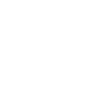

In [29]:
# Create LineString from coordinates
start, end = [(geom0.x, geom0.y), (geom1.x, geom1.y)]
line = LineString([start, end])
print(f"Geometry type: {str(type(line))}")
line


In [46]:
LineString(gdf.geometry).wkt


'LINESTRING (-0.933481 51.013545, -0.933481 51.013545, -0.933481 51.013545, -0.933481 51.013545, -0.933481 51.013545, -0.933481 51.013545, -0.933481 51.013545, -0.933481 51.013545, -0.933481 51.013545, -0.933481 51.013545, -0.933481 51.013545, -0.933481 51.013545, -0.933481 51.013545, -0.933481 51.013545, -0.933481 51.013545, -0.933481 51.013545, -0.933481 51.013545, -0.933481 51.013545, -0.933495 51.01354, -0.933509 51.013532, -0.933527 51.013514, -0.933552 51.013482, -0.933563 51.013471, -0.933597 51.013449, -0.933648 51.01343, -0.9337029999999999 51.013412, -0.933763 51.013395, -0.933812 51.013379, -0.933858 51.013365, -0.933906 51.013351, -0.933951 51.013339, -0.934001 51.013334, -0.9340540000000001 51.013327, -0.934107 51.013316, -0.934162 51.0133, -0.934219 51.013282, -0.9342780000000001 51.013262, -0.9343320000000001 51.013242, -0.934385 51.013222, -0.934438 51.013202, -0.934483 51.013186, -0.9345290000000001 51.013171, -0.934575 51.013152, -0.934617 51.013133, -0.934657 51.0131

1. Create a function, make_lines() that takes two sets of XY coordinates from a GeoDataFrame and adds them to a shapely LineString() constructor. Returns a DataFrame.

In [32]:
# def make_lines(gdf, df_out, i, geometry = 'geometry'):
#     geom0 = gdf.loc[i][geometry]
#     geom1 = gdf.loc[i + 1][geometry]
    
#     start, end = [(geom0.x, geom0.y), (geom1.x, geom1.y)]
#     line = LineString([start, end])
    
#     # Create a DataFrame to hold record
#     data = {'id': i,
#             'geometry': [line]}
#     df_line = pd.DataFrame(data, columns = ['id', 'geometry'])
    
#     # Add record DataFrame of compiled records
#     df_out = pd.concat([df_out, df_line])
#     return df_out

def make_lines(gdf, df_out):

    LineString(gdf.geometry).wkt
    return df_out

2. Loop through a GeoDataFrame, passing consecutive XY coordinate pairs to make_lines().

In [13]:
# initialize an output DataFrame
df = pd.DataFrame(columns = ['id', 'geometry'])

# Loop through each row of the input point GeoDataFrame
x = 0
while x < len(gdf) - 1:
    df = make_lines(gdf, df, x)
    x = x + 1
    
df.head()

id                                           geometry
0  0  LINESTRING (-0.933481 51.013545, -0.933481 51....
0  1  LINESTRING (-0.933481 51.013545, -0.933481 51....
0  2  LINESTRING (-0.933481 51.013545, -0.933481 51....
0  3  LINESTRING (-0.933481 51.013545, -0.933481 51....
0  4  LINESTRING (-0.933481 51.013545, -0.933481 51....

Having managed to create LineStrings for each consecutive pair of points, I piggybacked on that process to calculate change in elevation and time between each point. I did this by expanding my make_lines() function to carry out those calculations and place the results into columns with the ouput DataFrame.

In [47]:
def make_lines(gdf, df_out, i, elevation = 'ele', time = 'time', geometry = 'geometry'):
    # Get track coordinates
    geom0 = gdf.loc[i][geometry]
    geom1 = gdf.loc[i + 1][geometry]
    
    # Create LineString from coordinates
    start, end = [(geom0.x, geom0.y), (geom1.x, geom1.y)]
    line = LineString([start, end])
    
    # Calculate change in elevation
    elevation_change = gdf.loc[i + 1, elevation] - gdf.loc[i, elevation]
    
    # Calculate time betweent segments
    time_change = pd.to_datetime(gdf.loc[i + 1, time], infer_datetime_format=True) - pd.to_datetime(gdf.loc[i, time], infer_datetime_format=True)
    time_change_seconds = time_change.seconds
    
    # Create a DataFrame to hold record
    data = {'id': i,
            'elevation_change': elevation_change,
            'time_change': time_change_seconds,
            'geometry': [line]}
    df_line = pd.DataFrame(data, columns = ['id', 'elevation_change', 'time_change','geometry'])
    
    # Add record DataFrame of compiled records
    df_out = pd.concat([df_out, df_line])
    return df_out

With a function for creating the segments and doing calculations, all I need to do was initialize a new DataFrame, df, that matched the schema of the DataFrame being returned by make_lines(). While df starts as an empty DataFrame, it is populated as a while-loop runs make_lines() on each consecutive pair of points.

In [49]:
df = pd.DataFrame(columns = ['id', 'elevation_change', 'time_change', 'geometry'])

x = 0
while x < len(gdf) - 1:
    df_input = make_lines(gdf, df, x)
    df = df_input
    x = x + 1

    
df.head()

id  elevation_change time_change  \
0  0               0.0           1   
0  1               0.0           1   
0  2               0.0           1   
0  3               0.0           1   
0  4               0.0           1   

                                            geometry  
0  LINESTRING (-0.933481 51.013545, -0.933481 51....  
0  LINESTRING (-0.933481 51.013545, -0.933481 51....  
0  LINESTRING (-0.933481 51.013545, -0.933481 51....  
0  LINESTRING (-0.933481 51.013545, -0.933481 51....  
0  LINESTRING (-0.933481 51.013545, -0.933481 51....

Although the final version of df had a geometry column containing shapely LineStrings, the DataFrame still needed to be converted into a GeoDataFrame for both plotting and for calculating the length of each segment. To convert df into a GeoDataFrame, gdf_line, I passed the DataFrame and the coordinate reference system of the geometry column to a geopandas GeoDataFrame():

In [50]:
# crs = {'init': 'epsg:4326'}
crs = ('epsg:4326')
gdf_line = GeoDataFrame(df, crs=crs)
gdf_line.head()

id  elevation_change time_change  \
0  0               0.0           1   
0  1               0.0           1   
0  2               0.0           1   
0  3               0.0           1   
0  4               0.0           1   

                                            geometry  
0  LINESTRING (-0.93348 51.01355, -0.93348 51.01355)  
0  LINESTRING (-0.93348 51.01355, -0.93348 51.01355)  
0  LINESTRING (-0.93348 51.01355, -0.93348 51.01355)  
0  LINESTRING (-0.93348 51.01355, -0.93348 51.01355)  
0  LINESTRING (-0.93348 51.01355, -0.93348 51.01355)

Although the geometry column in df and gdf_line look the same, by converting df to a GeoDataFrame, the geometry column changed from a pandas Series to a geopandas GeoSeries.

In [51]:
print("Field types:")
print(f">> df['geometry']: {str(type(df['geometry']))}")
print(f">> gdf_line['geometry']: {str(type(gdf_line['geometry']))}")


Field types:
>> df['geometry']: <class 'pandas.core.series.Series'>
>> gdf_line['geometry']: <class 'geopandas.geoseries.GeoSeries'>


In [52]:
folium.GeoJson(gdf_line).add_to(m)
m



We're in the home stretch here! While I had managed to create line segments and derived time and elevation change for each line segment, I was missing a key measure: speed.

Speed = Distance/Time

My desire was to calculate miles per hour for each segment. I already had time, albeit in seconds. I didn't have the distance along each segment. Fortunately, geopandas has a length method for calculating distance. The catch was that it calculates length in the units of GeoDataFrame's coordinate reference system (CRS). Because gdf_line is based on WGS84, its units were in degrees. Luckily I was able to use geopanda's to_crs() method to briefly transform gdf_line into a local, foot-based CRS, NAD83 / North Carolina. I calculated the length of each segment and converted the value into miles, miles_travled. I then created a new column, mph, by converting time_change from seconds to hours and dividing miles_traveled by that value. As a final step re-transformed gdf_line back to WGS84.


In [22]:
# convert to GeoDataFrame to a crs from which we can derive linear measurements
gdf_line = gdf_line.to_crs(epsg = 2264)
# calculate miles per hour for each segment. Distance is calculated in meters, time in seconds. 
# They are converted to miles and hours, respectively, when creating the speed (mph) column.
gdf_line['miles_traveled'] = gdf_line.length * 0.000189394
gdf_line['mph'] = gdf_line['miles_traveled'] / (gdf_line['time_change'] * 0.000277778)
# convert back to original crs
gdf_line = gdf_line.to_crs(epsg = 4326)
gdf_line.head()

id  elevation_change time_change  \
0  0               0.0           1   
0  1               0.0           1   
0  2               0.0           1   
0  3               0.0           1   
0  4               0.0           1   

                                            geometry  miles_traveled mph  
0  LINESTRING (-0.93348 51.01354, -0.93348 51.01354)             0.0   0  
0  LINESTRING (-0.93348 51.01354, -0.93348 51.01354)             0.0   0  
0  LINESTRING (-0.93348 51.01354, -0.93348 51.01354)             0.0   0  
0  LINESTRING (-0.93348 51.01354, -0.93348 51.01354)             0.0   0  
0  LINESTRING (-0.93348 51.01354, -0.93348 51.01354)             0.0   0

To check my work I plotted gdf_line using folium. I was especially interested to see if the speed for each segment seemed in line with my own experience, so I symbolized by the mph column using folium's color mapping functionality.

In [32]:
import branca.colormap as cm
import math

f2 = folium.Figure(height = 400)
m2 = folium.Map([centre_lat, centre_long], zoom_start = 15)

max_mph = math.ceil(gdf_line['mph'].max())
linear = cm.linear.YlOrRd_04.scale(0,max_mph)
gps_lyr = folium.GeoJson(gdf_line,
                         style_function = lambda feature: {
                             'color': linear(feature['properties']['mph']),
                             'weight': 5})       

gps_lyr.add_child
    
m2.add_child(linear)
m2.add_child(gps_lyr)
m2.add_to(f2)